<a href="https://colab.research.google.com/github/bloodclaw2000/Mala-Simulations/blob/main/Quantum_Espresso_Input_Files_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the Quantum Espresso Binary

In [1]:
%%capture
# Clone the QE git
!git clone https://github.com/QEF/q-e.git
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
# enter the q-e folder
%cd q-e
# run the configure file
# !DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp
!!DFLAGS='-D__FFTW3 ' FFT_LIBS='-lfftw3'  ./configure
# computation time ~1 minute

Install `ase` for preparing input files, reading output files and visualization

In [2]:
%%capture
!apt install ase #computation time ~30 seconds

Run the cell to make `pw.x` binary
If you need to make any other binary like `dos.x` or `bands.x`. Replace the `pw` with `dos` or `bands`

In [3]:
%%capture
!make pw #computation time ~5-7 minutes


In [4]:
!make pp

test -d bin || mkdir bin
( cd UtilXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/UtilXlib'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/q-e/UtilXlib'
cd install ; make -f extlibs_makefile libcuda
make[1]: Entering directory '/content/q-e/install'
make[1]: Nothing to be done for 'libcuda'.
make[1]: Leaving directory '/content/q-e/install'
( cd LAXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/LAXlib'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/q-e/LAXlib'
( cd FFTXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/FFTXlib'
( cd src ; make all || exit 1 )
make[2]: Entering directory '/content/q-e/FFTXlib/src'
make[2]: Nothing to be done for 'all'.
make[2]: Leaving directory '/content/q-e/FFTXlib/src'
make[1]: Leaving directory '/content/q-e/FFTXlib'
( cd upflib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/upflib'

Now We get MALA

In [5]:
!git clone https://github.com/mala-project/mala.git
%cd mala
!pip install -e .

Cloning into 'mala'...
remote: Enumerating objects: 21807, done.
remote: Counting objects: 100% (4112/4112), done.
remote: Compressing objects: 100% (1041/1041), done.
remote: Total 21807 (delta 3091), reused 3901 (delta 3049), pack-reused 17695
Receiving objects: 100% (21807/21807), 56.98 MiB | 26.19 MiB/s, done.
Resolving deltas: 100% (16249/16249), done.
/content/q-e/mala
Obtaining file:///content/q-e/mala
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━

**We import needed libraries**

In [6]:
import numpy as np
import mala
import subprocess
import ase
import ase.io.espresso
from ase import Atoms
from ase.visualize import view
import os
from os.path import join as pj
import matplotlib.pyplot as plt
import re
import random
import time
from ase.visualize.plot import plot_atoms


Create a folder named "Be""Si" "Si2" inside "Data_Gen" to download and keep all the files needed including the input files and pseudopotential files (in Data_Gen/pseudo). Also create Data_Gen/tmp folder

After creating the folder, upload the pseudopotential file in this folder.

In [10]:
# Navigating into your folder.
%cd ..
%cd ..
%cd content/Data_Gen/Be/
%ls

/
/
/content/Data_Gen/Be


BASIC FUNCTIONS

In [40]:
def generate_random_value(min_val, max_val):
    return random.uniform(min_val, max_val)
def modify_matrix(matrix, change):
    modified_matrix = []
    for row in matrix:
        modified_row = []
        for value in row:
            random_change = generate_random_value(-change, change)
            modified_value = value + random_change
            modified_row.append(modified_value)
        modified_matrix.append(modified_row)
    return modified_matrix
def modify_file(qe_input,change):
    pattern = r'CELL_PARAMETERS angstrom\n((?:.*\n){3})'
    match = re.search(pattern, qe_input)
    if match:
        matrix_lines = match.group(1).strip().split('\n')
        matrix = [[float(value) for value in line.split()] for line in matrix_lines]
        # Modify the matrix values
          # Minimum change value
        modified_matrix = modify_matrix(matrix, change)
        #print(modified_matrix)
        # Replace the original matrix with the modified one
        modified_matrix_lines = '\n'.join([' '.join(map(str, row)) for row in modified_matrix])
        modified_content  = re.sub(pattern, f'CELL_PARAMETERS angstrom\n{modified_matrix_lines}', qe_input)
        return modified_content
def modify_atomic_positions(input_string, position_type, change):
    # Function to generate a random value within a specified range
    # Find the matrix under "ATOMIC_POSITIONS"
    pattern = rf'ATOMIC_POSITIONS {position_type}\n((?:.*\n)+)'
    match = re.search(pattern, input_string)
    if match:
        positions_lines = match.group(1).strip().split('\n')
        positions = [[tokens[0], float(tokens[1]), float(tokens[2]), float(tokens[3])] for line in positions_lines for tokens in [line.split()]]

        # Modify the positions values
        modified_positions = []
        for atom, x, y, z in positions:
            random_change_x = generate_random_value(-change,change)
            random_change_y = generate_random_value(-change,change)
            random_change_z = generate_random_value(-change,change)
            modified_x = x + random_change_x
            modified_y = y + random_change_y
            modified_z = z + random_change_z
            modified_positions.append((atom, modified_x, modified_y, modified_z))

        # Replace the original positions with the modified ones
        modified_positions_lines = '\n'.join([f"{atom} {x} {y} {z}" for atom, x, y, z in modified_positions])
        modified_content = re.sub(pattern, f'ATOMIC_POSITIONS {position_type}\n{modified_positions_lines}', input_string)

        return modified_content
    else:
        print(f"Positions not found for type '{position_type}' in the input string.")
        return None

# Prepare the input file

In [12]:
qe_input = """
&CONTROL
   calculation      = 'scf'
   verbosity        = 'high'
   restart_mode     = 'from_scratch'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = '../tmp/Be'
   prefix           = 'Be'
   pseudo_dir       = '../pseudo/'
/
&SYSTEM
   ibrav            = 0
   nbnd             = 4
   ecutwfc          = 40
   ecutrho          = 160
   nosym            = .true.
   noinv            = .true.
   occupations      = 'smearing'
   degauss          = 0.0018874
   smearing         = 'fermi-dirac'
   ntyp             = 1
   nat              = 2
/
&ELECTRONS
   conv_thr         = 0.02
   mixing_mode      = 'plain'
   mixing_beta      = 0.1
/
ATOMIC_SPECIES
Be 9.0121831 Be.pbe-n-rrkjus_psl.1.0.0.UPF

K_POINTS automatic
 8 8 8 0 0 0
ATOMIC_POSITIONS angstrom
  Be 1.7528828707 0.3210037143 2.6776725841
  Be -0.6229700257 1.6360627414 0.8922054159

CELL_PARAMETERS angstrom
  2.25982586776780 0.00000000000000 0.00000000000000
  -1.12991293388390 1.95706569713361 0.00000000000000
  0.00000000000000 0.00000000000000 3.56987856087494


"""
pp_input = """
&inputpp
 outdir='../tmp/Be'
 prefix='Be'
 plot_num=3
 emin=-5.0
 emax=20.0
 delta_e=2.5
 degauss_ldos=5.0

/
&plot
 iflag=3
 output_format=6
 fileout='Be_ldos.cube'
/
"""

# We write the input script
with open("be.pw.in", "w") as f:
    f.write(qe_input)
with open("be.pp.ldos", "w") as f:
    f.write(pp_input)

Visualize the Be atoms

In [13]:
import ase.io.espresso
from ase import Atoms
from ase.visualize import view
input_file = ase.io.espresso.read_espresso_in('be.pw.in')

atoms = Atoms(input_file)
view(atoms,viewer='x3d')

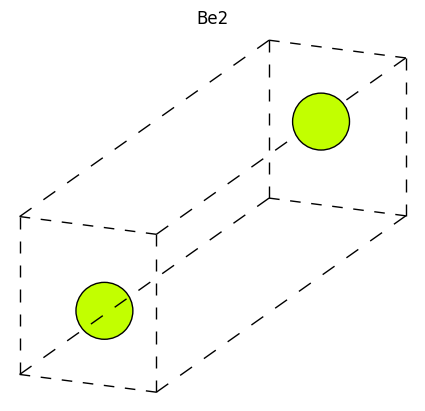

In [14]:

fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.3, rotation=('45x,45y,90z'))
ax.set_title(atoms.get_chemical_formula())
ax.set_axis_off()
plt.show()

# Run the DFT code

Note: Check the directories for pseudopotential file and output file!

In [18]:
! /content/q-e/bin/pw.x  -in be.pw.in > be.pw.out

In [19]:
# create a list for lattice constants to be tested
cell_difference = 0.4
# find the "lattice constant" line in the input file
lat_cons_index = qe_input.find('CELL_PARAMETERS angstrom')
#print(qe_input)

In [20]:
#to check if espresso is installed
#!  /content/q-e/bin/pw.x

now we create a loop in lattice constants

In [21]:
change = 0.2
maxiter = 8
for i in range(1, maxiter + 1):
    # Modify the matrix values
    time1 = time.time()
    modified_content = modify_file(qe_input, change)
    modified_pp_input = re.sub(r"(fileout\s*=\s*').*(')", rf"\1Be{i}_ldos.cube\2", pp_input)
    # Write the modified content to the new input file
    new_input_filename = f'Be{i}.pw.in'
    new_input_filename_ldos = f'Be{i}.pp.ldos'
    #modified_pp_input = pp_input.replace("fileout='Be_ldos.cube'", f"fileout='Be{i}_ldos.cube'")
    #modified_content = modified_content.replace("outdir='../tmp/Be'", f"outdir='../tmp/Be{i}'")
    #modified_pp_input = pp_input.replace("outdir='../tmp/Be'", f"outdir='../tmp/Be{i}'")
    #modified_content = modified_content.replace("prefix='Be'", f"prefix='Be{i}'")
   # modified_pp_input = pp_input.replace("prefix='Be'", f"prefix='Be{i}'")
    #print(modified_content)
    with open(new_input_filename, 'w') as new_input_file:
        new_input_file.write(modified_content)
    with open(new_input_filename_ldos, 'w') as pp_input_file:
        pp_input_file.write(modified_pp_input)

    !  /content/q-e/bin/pw.x -in {new_input_filename} > Be{i}.pw.out
    !  /content/q-e/bin/pp.x -in {new_input_filename_ldos}
    #os.system(f"mpirun -np 4 pp.x -in {new_input_filename_ldos}")
    print(f"DONE DFT ITERATION {i} of {maxiter} in {time.time() - time1:.2f}s")


     Program POST-PROC v.7.3.1 starts on  7May2024 at  9:55: 9 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     2410 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     ../tmp/Be/Be.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBE
                           (   1   4   3   4   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-vecto

Now we'll create the Si files

In [40]:
!cat Be1.pw.out


     Program PWSCF v.7.3.1 starts on  7May2024 at  9:30:20 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     7954 MiB available memory on the printing compute node when the environment starts

     Reading input from Be1.pw.in

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angular momentum in pseudopotentials (lmaxx) =  4


     G-vector sticks info
     --------------------
     sticks:   dense  smooth 

In [29]:

%cd Data_Gen/Si
%ls

/content/Data_Gen/Si


INPUT FILES

In [30]:
qe_input = """
&CONTROL
   calculation      = 'scf'
   verbosity        = 'high'
   restart_mode     = 'from_scratch'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = '../tmp/Si'
   prefix           = 'Si'
   pseudo_dir       = '../pseudo/'
/
&SYSTEM
   ibrav            = 0


   ecutwfc          = 40
   ecutrho          = 160
   nosym            = .true.
   noinv            = .true.
   occupations      = 'smearing'
   degauss          = 0.0018874
   smearing         = 'fermi-dirac'
   ntyp             = 1
   nat              = 2
/
&ELECTRONS
   conv_thr         = 0.02
   mixing_mode      = 'plain'
   mixing_beta      = 0.1
/

ATOMIC_SPECIES
 Si  28.086  Si.pz-vbc.UPF

K_POINTS automatic
8 8 8 0 0 0

CELL_PARAMETERS angstrom
 2.6871900000       0.0000000000       0.0000000000
-1.3435950001       2.3271748049       0.0000000000
 0.0000000000       0.0000000000       4.5928309194

ATOMIC_POSITIONS crystal
Si           0.3333333333       0.6666666666       0.2500000000
Si           0.6666666667       0.3333333333       0.7500000000


"""
pp_input = """
&inputpp
 outdir='../tmp/Si'
 prefix='Si'
 plot_num=3
 emin=-5.0
 emax=20.0
 delta_e=2.5
 degauss_ldos=5.0

/
&plot
 iflag=3
 output_format=6
 fileout='Si_ldos.cube'
/
"""
# We write the input script
with open("Si.pw.in", "w") as f:
    f.write(qe_input)
with open("Si.pp.ldos", "w") as f:
    f.write(pp_input)


now we create a loop in lattice constants

```
# This is formatted as code
```



In [31]:
%ls

Si.pp.ldos  Si.pw.in


In [32]:
cell_difference = 0.4
# find the "lattice constant" line in the input file
lat_cons_index = qe_input.find('CELL_PARAMETERS angstrom')
#now we create a loop in lattice constants
change = 0.2
maxiter = 8


In [33]:
for i in range(1, maxiter + 1):
    # Modify the matrix values
    time1 = time.time()
    modified_content = modify_file(qe_input, change)
    modified_pp_input = re.sub(r"(fileout\s*=\s*').*(')", rf"\1Si{i}_ldos.cube\2", pp_input)
    # Write the modified content to the new input file
    new_input_filename = f'Si{i}.pw.in'
    new_input_filename_ldos = f'Si{i}.pp.ldos'
    #modified_pp_input = pp_input.replace("fileout='Si_ldos.cube'", f"fileout='Si{i}_ldos.cube'")
    #modified_content = modified_content.replace("outdir='../tmp/Si'", f"outdir='../tmp/Si{i}'")
    #modified_pp_input = pp_input.replace("outdir='../tmp/Si'", f"outdir='../tmp/Si{i}'")
    #modified_content = modified_content.replace("prefix='Si'", f"prefix='Si{i}'")
   # modified_pp_input = pp_input.replace("prefix='Si'", f"prefix='Si{i}'")
    #print(modified_pp_input)

    with open(new_input_filename, 'w') as new_input_file:
        new_input_file.write(modified_content)
    with open(new_input_filename_ldos, 'w') as pp_input_file:
        pp_input_file.write(modified_pp_input)


    !  /content/q-e/bin/pw.x -in {new_input_filename} > Si{i}.pw.out
    !  /content/q-e/bin/pp.x -in {new_input_filename_ldos}
    print(f"DONE DFT ITERATION {i} of {maxiter} in {time.time() - time1:.2f}s")



     Program POST-PROC v.7.3.1 starts on  7May2024 at 10: 0:11 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     2194 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     ../tmp/Si/Si.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PZ
                           (   1   1   0   0   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-vector

**Let's modify the atomic positions now**

In [34]:
%cd ..
%cd SiPositions

/content/Data_Gen
/content/Data_Gen/SiPositions


In [35]:
qe_input = """
&CONTROL
   calculation      = 'scf'
   verbosity        = 'high'
   restart_mode     = 'from_scratch'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = '../tmp/Si'
   prefix           = 'Si'
   pseudo_dir       = '../pseudo/'
/
&SYSTEM
   ibrav            = 0


   ecutwfc          = 40
   ecutrho          = 160
   nosym            = .true.
   noinv            = .true.
   occupations      = 'smearing'
   degauss          = 0.0018874
   smearing         = 'fermi-dirac'
   ntyp             = 1
   nat              = 2
/
&ELECTRONS
   conv_thr         = 0.02
   mixing_mode      = 'plain'
   mixing_beta      = 0.1
/

ATOMIC_SPECIES
 Si  28.086  Si.pz-vbc.UPF

K_POINTS automatic
8 8 8 0 0 0

CELL_PARAMETERS angstrom
 2.6871900000       0.0000000000       0.0000000000
-1.3435950001       2.3271748049       0.0000000000
 0.0000000000       0.0000000000       4.5928309194

ATOMIC_POSITIONS crystal
Si           0.3333333333       0.6666666666       0.2500000000
Si           0.6666666667       0.3333333333       0.7500000000


"""
pp_input = """
&inputpp
 outdir='../tmp/Si'
 prefix='Si'
 plot_num=3
 emin=-5.0
 emax=20.0
 delta_e=2.5
 degauss_ldos=5.0

/
&plot
 iflag=3
 output_format=6
 fileout='Si_ldos.cube'
/
"""
# We write the input script
with open("Si.pw.in", "w") as f:
    f.write(qe_input)
with open("Si.pp.ldos", "w") as f:
    f.write(pp_input)

In [54]:
%ls


Si1.pp.ldos             tmp.pp001Si6_ldos.cube  tmp.pp005Si2_ldos.cube  tmp.pp008Si7_ldos.cube
Si1.pw.in               tmp.pp001Si7_ldos.cube  tmp.pp005Si3_ldos.cube  tmp.pp008Si8_ldos.cube
Si1.pw.out              tmp.pp001Si8_ldos.cube  tmp.pp005Si4_ldos.cube  tmp.pp009
Si2.pp.ldos             tmp.pp002               tmp.pp005Si5_ldos.cube  tmp.pp009Si1_ldos.cube
Si2.pw.in               tmp.pp002Si1_ldos.cube  tmp.pp005Si6_ldos.cube  tmp.pp009Si2_ldos.cube
Si2.pw.out              tmp.pp002Si2_ldos.cube  tmp.pp005Si7_ldos.cube  tmp.pp009Si3_ldos.cube
Si3.pp.ldos             tmp.pp002Si3_ldos.cube  tmp.pp005Si8_ldos.cube  tmp.pp009Si4_ldos.cube
Si3.pw.in               tmp.pp002Si4_ldos.cube  tmp.pp006               tmp.pp009Si5_ldos.cube
Si3.pw.out              tmp.pp002Si5_ldos.cube  tmp.pp006Si1_ldos.cube  tmp.pp009Si6_ldos.cube
Si4.pp.ldos             tmp.pp002Si6_ldos.cube  tmp.pp006Si2_ldos.cube  tmp.pp009Si7_ldos.cube
Si4.pw.in               tmp.pp002Si7_ldos.cube  tmp.pp006Si3_ld

now we create a loop in lattice constants


In [55]:
cell_difference = 0.1
# find the "lattice constant" line in the input file
lat_cons_index = qe_input.find('CELL_PARAMETERS angstrom')
#now we create a loop in lattice constants
change = 0.1
maxiter = 12


In [56]:
for i in range(1, maxiter + 1):
    # Modify the matrix values
    time1 = time.time()

    modified_content = modify_atomic_positions(qe_input, "crystal", change)

    modified_pp_input = re.sub(r"(fileout\s*=\s*').*(')", rf"\1Si{i}_ldos.cube\2", pp_input)
    # Write the modified content to the new input file
    new_input_filename = f'Si{i}.pw.in'
    new_input_filename_ldos = f'Si{i}.pp.ldos'
    #modified_pp_input = pp_input.replace("fileout='Si_ldos.cube'", f"fileout='Si{i}_ldos.cube'")
    #modified_content = modified_content.replace("outdir='../tmp/Si'", f"outdir='../tmp/Si{i}'")
    #modified_pp_input = pp_input.replace("outdir='../tmp/Si'", f"outdir='../tmp/Si{i}'")
    #modified_content = modified_content.replace("prefix='Si'", f"prefix='Si{i}'")
   # modified_pp_input = pp_input.replace("prefix='Si'", f"prefix='Si{i}'")
    #print(modified_pp_input)

    with open(new_input_filename, 'w') as new_input_file:
        new_input_file.write(modified_content)
    with open(new_input_filename_ldos, 'w') as pp_input_file:
        pp_input_file.write(modified_pp_input)


    !  /content/q-e/bin/pw.x -in {new_input_filename} > Si{i}.pw.out
    !  /content/q-e/bin/pp.x -in {new_input_filename_ldos}
    print(f"DONE DFT ITERATION {i} of {maxiter} in {time.time() - time1:.2f}s")



     Program POST-PROC v.7.3.1 starts on  7May2024 at 10:17:34 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     1682 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     ../tmp/Si/Si.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PZ
                           (   1   1   0   0   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-vector

Now we create a ZIp and download manually


In [57]:
%cd ..
%ls
!zip -r /content/file.zip /content/Data_Gen

/content/Data_Gen
Be/           Si11.pp.ldos  Si1.pp.ldos  Si3.pp.ldos  Si5.pp.ldos  Si7.pp.ldos  Si9.pp.ldos
pseudo/       Si11.pw.in    Si1.pw.in    Si3.pw.in    Si5.pw.in    Si7.pw.in    Si9.pw.in
Si/           Si11.pw.out   Si1.pw.out   Si3.pw.out   Si5.pw.out   Si7.pw.out   Si9.pw.out
Si10.pp.ldos  Si12.pp.ldos  Si2.pp.ldos  Si4.pp.ldos  Si6.pp.ldos  Si8.pp.ldos  SiPositions/
Si10.pw.in    Si12.pw.in    Si2.pw.in    Si4.pw.in    Si6.pw.in    Si8.pw.in    tmp/
Si10.pw.out   Si12.pw.out   Si2.pw.out   Si4.pw.out   Si6.pw.out   Si8.pw.out
updating: content/Data_Gen/ (stored 0%)
updating: content/Data_Gen/tmp/ (stored 0%)
updating: content/Data_Gen/tmp/Be/ (stored 0%)
updating: content/Data_Gen/tmp/Be/Be.xml (deflated 81%)
updating: content/Data_Gen/tmp/Be/Be.save/ (stored 0%)
updating: content/Data_Gen/tmp/Be/Be.save/wfc63.dat (deflated 14%)
updating: content/Data_Gen/tmp/Be/Be.save/wfc252.dat (deflated 14%)
updating: content/Data_Gen/tmp/Be/Be.save/wfc55.dat (deflated 14%)
updating:

In [58]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>